## Setup

In [43]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/WignerMolecule.jl/analysis`


Status `~/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.8
⌃ [780c37f4] Carlo v0.2.6
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.1
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.3
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.16
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [44]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [45]:
function etak_tranform(etak_corrs)
    result = map(Iterators.product(1:3, 1:3)) do (x, y)
        etak_corrs[:, :, x, y]
    end
    return reshape(result, (9,))
end

Γ(corrs) = abs.(getindex.(corrs, 1, 1))
function M(corrs)
    Ms = Vector(undef, length(corrs))
    for i in eachindex(corrs)
        Lx, Ly = size(corrs[i])
        Ms[i] = abs(corrs[i][div(Lx, 2)+1, 1])
    end
    return Ms
end
function half_M(corrs)
    Ms = Vector(undef, length(corrs))
    for i in eachindex(corrs)
        Lx, Ly = size(corrs[i])
        Ms[i] = abs(corrs[i][div(Lx, 4)+1, 1])
    end
    return Ms
end

function separate_etaks!(data::AbstractDataFrame)
    col_names = [:ηk_xx, :ηk_yx, :ηk_zx, :ηk_xy, :ηk_yy, :ηk_zy, :ηk_xz, :ηk_yz, :ηk_zz]
    select!(
        data,
        Not(:etak_corrs),
        :etak_corrs => (corrs -> etak_tranform.(corrs)) => col_names,
    )
    transform!(
        data,
        col_names .=> Γ,
        col_names .=> M,
        col_names .=> half_M
    )
    return nothing
end

function separate_spinks!(data::AbstractDataFrame)
    transform!(
        data,
        :spink_corrs .=> Γ,
        :spink_corrs .=> M,
        :spink_corrs .=> half_M
    )
    return nothing
end

function clean_corrs!(data::AbstractDataFrame)
    separate_etaks!(data)
    separate_spinks!(data)
end

norm2(v) = sum(abs2.(v))

norm2 (generic function with 1 method)

In [46]:
function gen_path(Lx, Ly)
    pos = (1, 1)
    path = [pos]
    while pos[1] < div(Lx, 2) + 1
        pos = pos .+ (1, 0)
        push!(path, pos)
    end
    M_pos = length(path)
    while pos[2] < div(Ly, 3, RoundNearest) + 1
        pos = pos .+ (1, 2)
        push!(path, pos)
    end
    K_pos = length(path)
    while pos[1] > 2
        pos = pos .- (2, 1)
        push!(path, pos)
    end
    return (path, M_pos, K_pos)
end

gen_path (generic function with 1 method)

In [47]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## Zero-field Runs

In [6]:
results = JobResult("../jobs", "stripe-anneal")
clean_corrs!(results.data)

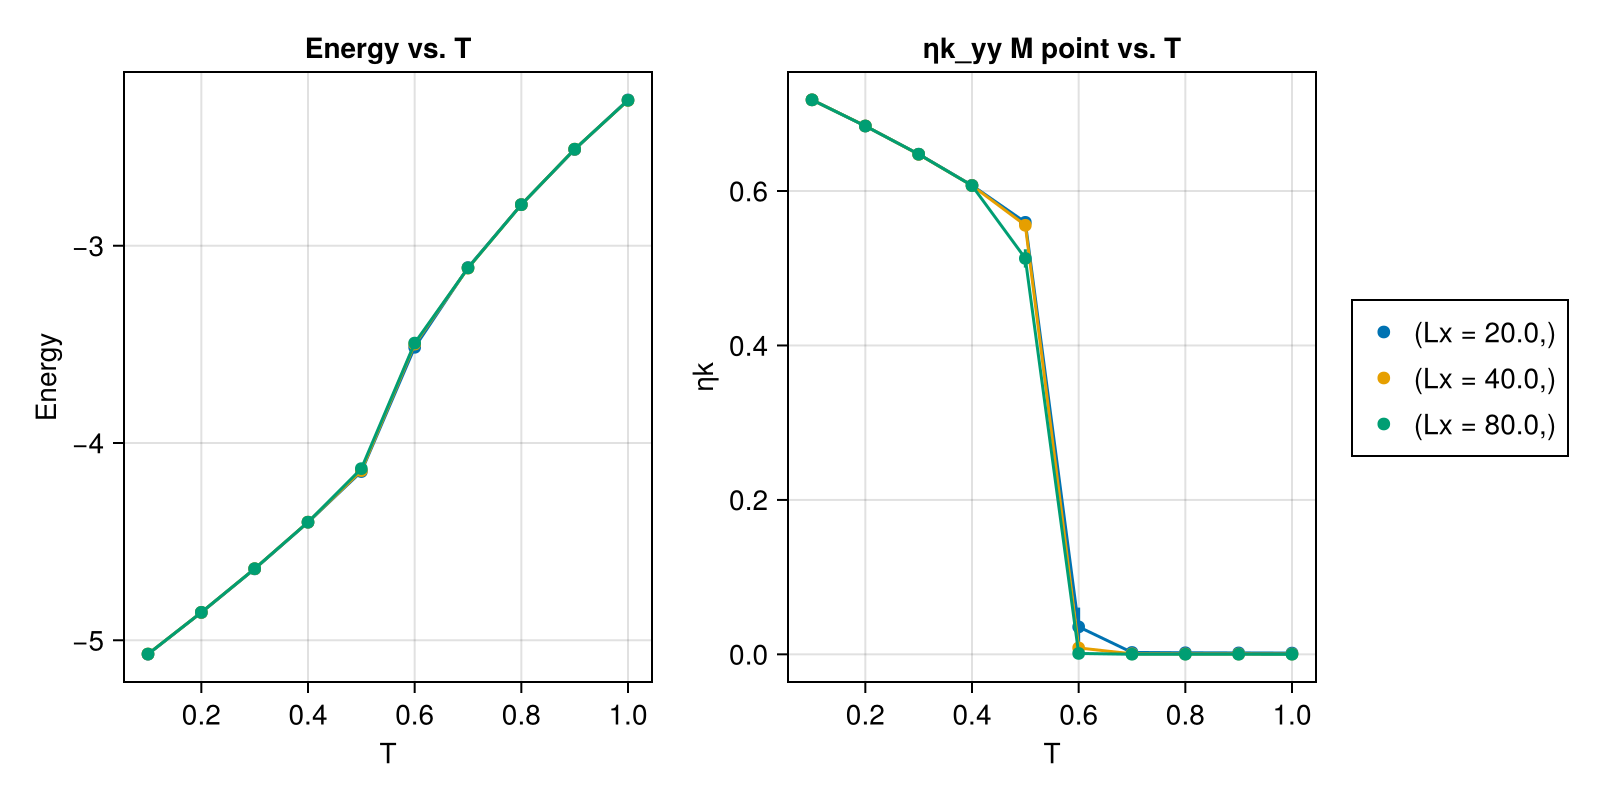

In [7]:
fig = Figure(size=(800, 400))

fig[1,1] = ax_e = Axis(fig, title="Energy vs. T", xlabel="T", ylabel="Energy")
generate_plot!(ax_e, :T, :Energy, [:Lx], results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηk_yy M point vs. T", xlabel="T", ylabel="ηk")
generate_plot!(ax_η, :T, :ηk_yy_M, [:Lx], results.data; line=true)

Legend(fig[1,3], ax_η)
fig

In [8]:
mctimes = get_mctime_data(results, :etak_corrs)
separate_etaks!.(mctimes)

30-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

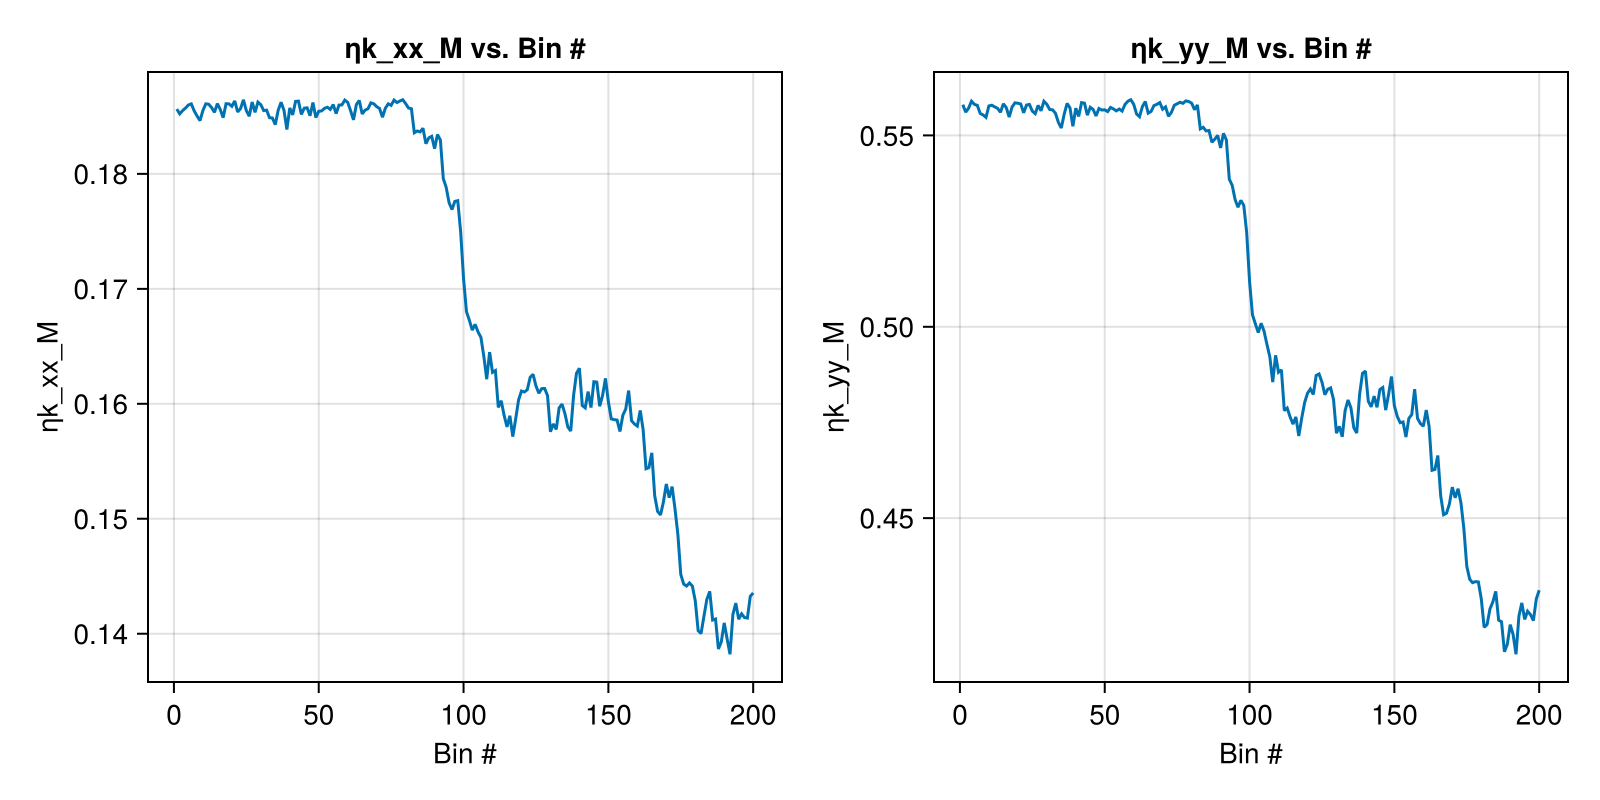

In [13]:
CairoMakie.activate!()
i = 25
k_pos = (1, 11)

var1 = :ηk_xx_M
var2 = :ηk_yy_M
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(mctimes[i][:, var1]))
lines!(ax2, abs.(mctimes[i][:, var2]))
fig

In [10]:
spink_corrs = results[:spink_corrs]
nothing

In [11]:
CairoMakie.activate!()
task_no = 10
Lx, Ly = size(spink_corrs[task_no])

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Origin-Γ-M-Origin Spink Correlations",
    ylabel="ln(S{k} ⋅ S{-k})"
)
log_corrs = log.(corrs)
scatter!(ax, log_corrs)
errorbars!(ax, 1:length(path), getfield.(log_corrs, :val), getfield.(log_corrs, :err))
lines!(ax, log_corrs)
scatter!(ax, Γ_pos, log(corrs[Γ_pos].val), color=:red, label="Γ")
scatter!(ax, M_pos, log(corrs[M_pos].val), color=:orange, label="M")
axislegend()
fig

UndefVarError: UndefVarError: `corrs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

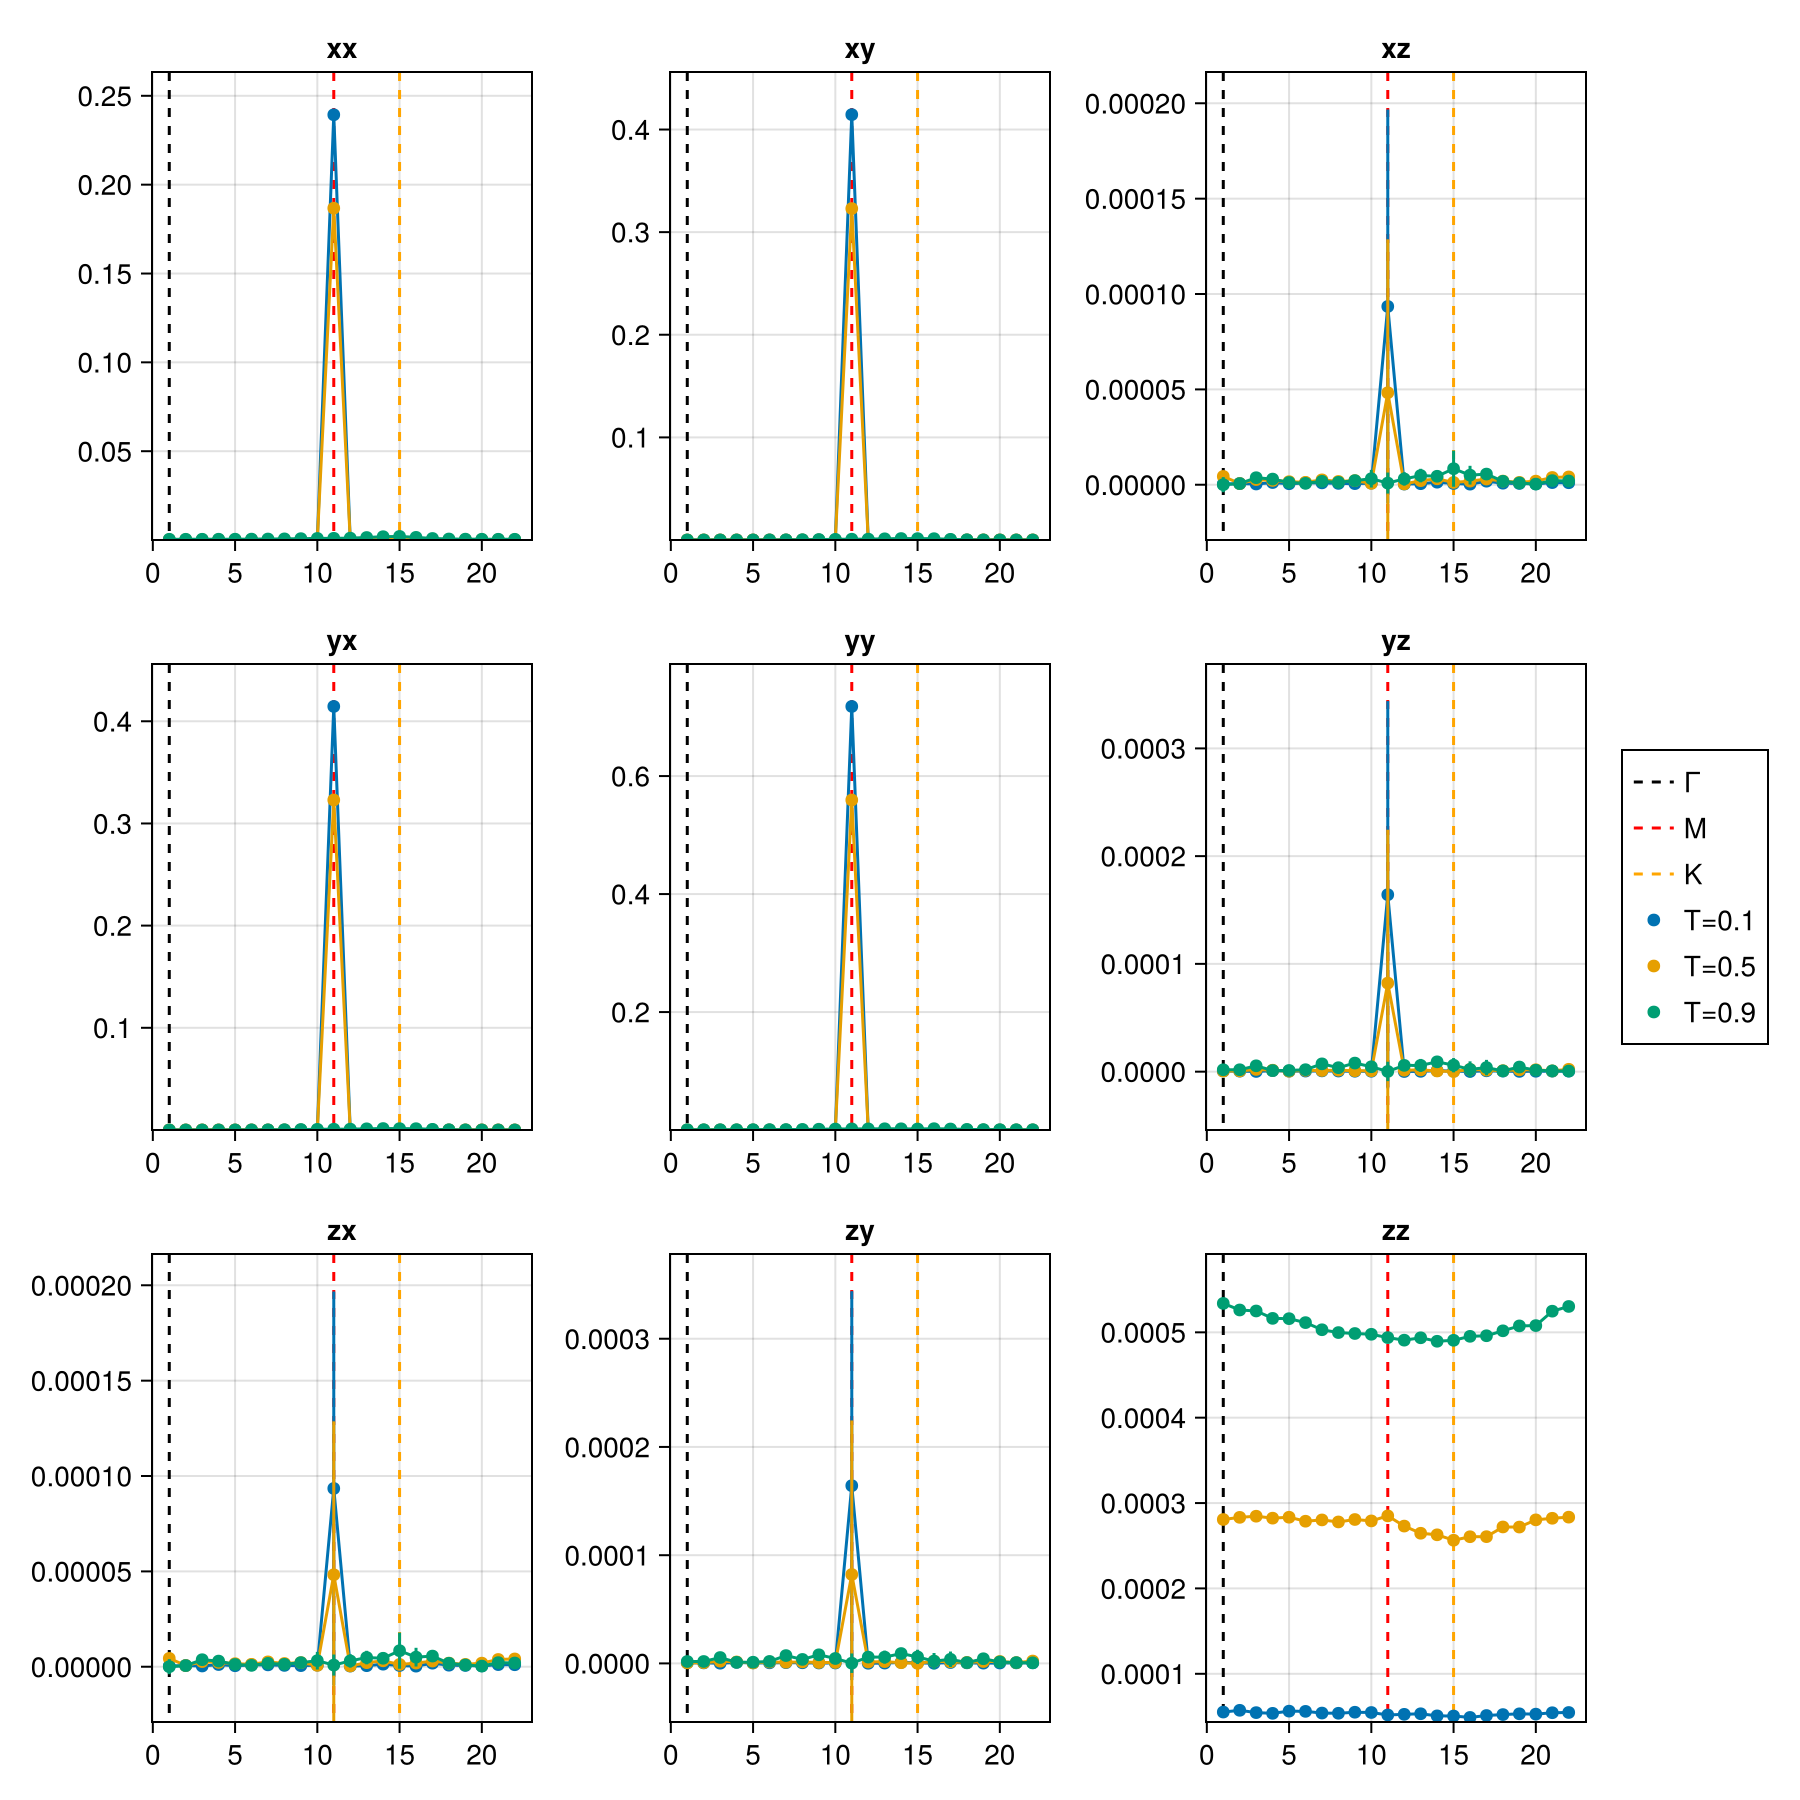

In [12]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Ts = results[:T]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 9]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="T=$(Ts[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

## Annealed Bias Field

In [48]:
bias_results = JobResult("../jobs", "stripe-bias")

JobResult("../jobs", "stripe-bias", 33×40 DataFrame
 Row │ ηk_M                               ηz               sk_corr_Γ         T ⋯
     │ Array…                             Measurem…        Measurem…         F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Complex{Measurement{Float64}}[0.…  0.013382±7.7e-5  0.0004581±9.7e-6    ⋯
   2 │ Complex{Measurement{Float64}}[0.…  0.01339±0.0001   0.000442±1.4e-5
   3 │ Complex{Measurement{Float64}}[0.…  0.013562±8.9e-5  0.0004502±8.1e-6
   4 │ Complex{Measurement{Float64}}[0.…  0.01352±0.00011  0.0004301±8.2e-6
   5 │ Complex{Measurement{Float64}}[0.…  0.0134±0.00012   0.0004274±5.8e-6    ⋯
   6 │ Complex{Measurement{Float64}}[0.…  0.013543±9.0e-5  0.0004133±9.9e-6
   7 │ Complex{Measurement{Float64}}[0.…  0.01337±0.00013  0.0004258±8.3e-6
   8 │ Complex{Measurement{Float64}}[0.…  0.01346±0.00012  0.000421±1.1e-5
  ⋮  │                 ⋮                         ⋮                ⋮            ⋱
  27 │ C

In [49]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="M point η_xx vs. B", xlabel="B", ylabel="ηxx")
generate_plot!(ax_s, :B, :ηk_corr_M, [:T], bias_results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="M point η_yy vs. B", xlabel="B", ylabel="ηyy")
generate_plot!(ax_η, :B, :ηk_yy_M, [:T], bias_results.data; line=true)
Legend(fig[1,3], ax_η)
fig

FieldError: FieldError: type Array has no field `val`, available fields: `ref`, `size`

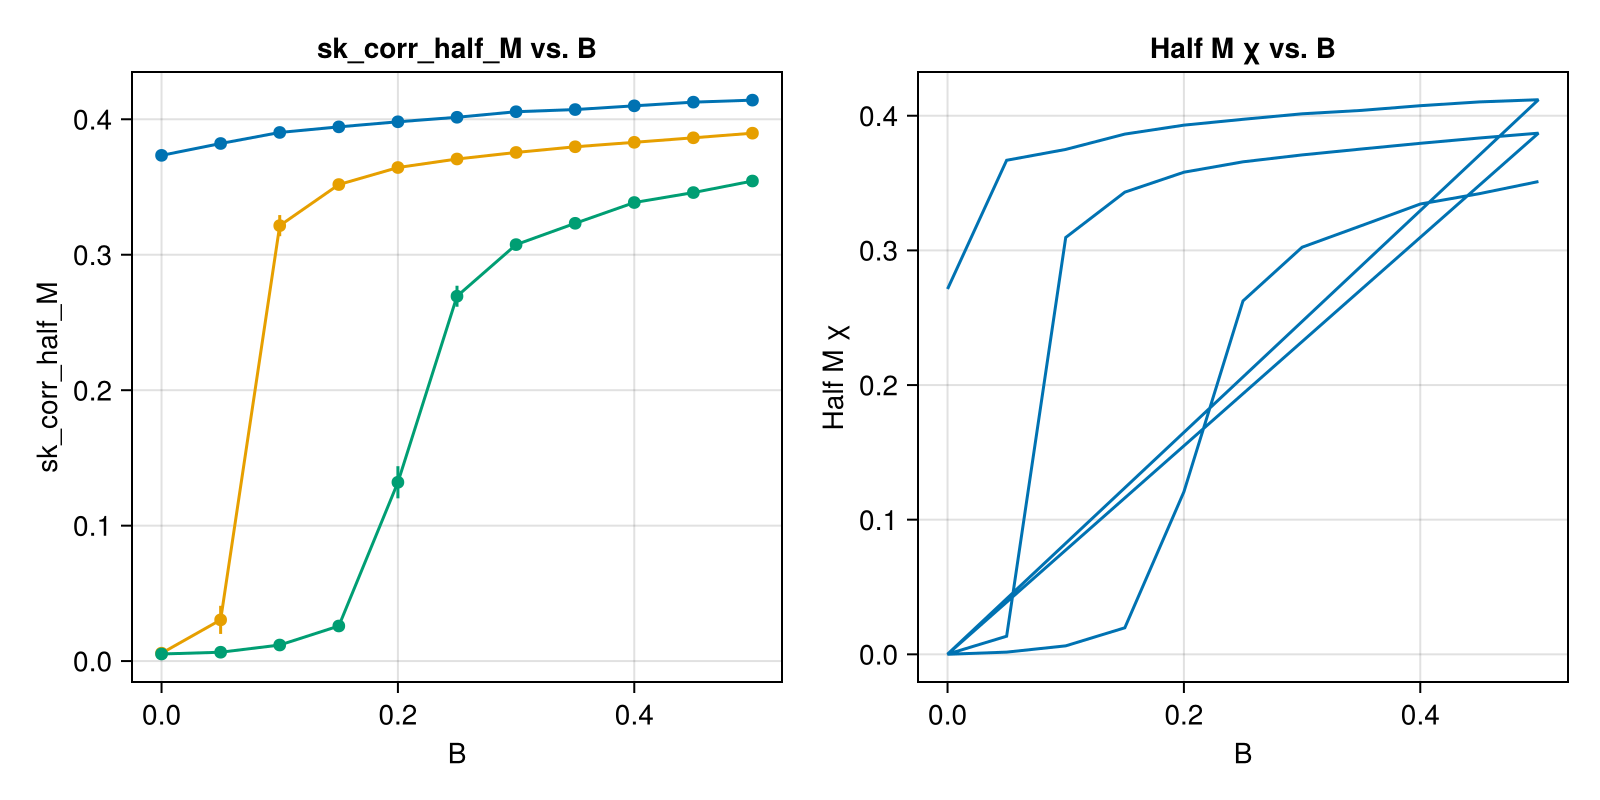

In [ ]:
CairoMakie.activate!()
var1 = :sk_corr_half_M
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. B", xlabel="B", ylabel="$var1")
generate_plot!(ax1, :B, var1, [:T], bias_results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="Half M χ vs. B", xlabel="B", ylabel="Half M χ")
sk_half_M = norm2.(bias_results.data[:, :sk_half_M])
χ = bias_results.data[:, :sk_corr_half_M] - sk_half_M
lines!(ax2, bias_results.data[:, :B], sk_half_M)
fig

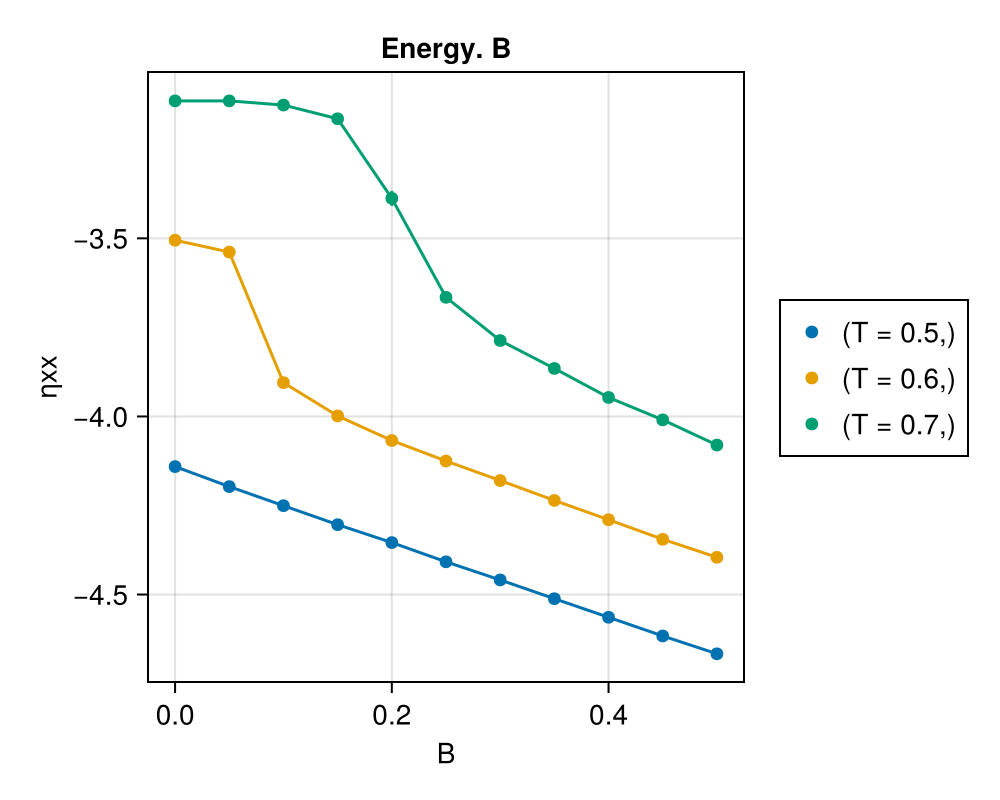

In [51]:
CairoMakie.activate!()

fig = Figure(size=(500, 400))
fig[1,1] = ax_s = Axis(fig, title="Energy. B", xlabel="B", ylabel="ηxx")
generate_plot!(ax_s, :B, :Energy, [:T], bias_results.data; line=true)
Legend(fig[1,2], ax_s)
fig

In [56]:
bias_mctimes = get_mctime_data(bias_results, :sk_half_M, :sk_corr_half_M)

33-element Vector{DataFrame}:
 100×2 DataFrame
 Row │ sk_half_M                          sk_corr_half_M 
     │ SubArray…                          SubArray…      
─────┼───────────────────────────────────────────────────
   1 │ ComplexF64[0.339815+0.338471im, …  fill(0.376272)
   2 │ ComplexF64[0.346083+0.3439im, -0…  fill(0.372025)
   3 │ ComplexF64[0.38077+0.376516im, -…  fill(0.384828)
   4 │ ComplexF64[0.389604+0.386564im, …  fill(0.382514)
   5 │ ComplexF64[0.36918+0.367065im, -…  fill(0.371333)
   6 │ ComplexF64[0.400135+0.396089im, …  fill(0.382968)
   7 │ ComplexF64[0.404884+0.400972im, …  fill(0.387188)
   8 │ ComplexF64[0.39732+0.394552im, -…  fill(0.371358)
  ⋮  │                 ⋮                        ⋮
  94 │ ComplexF64[0.360618+0.358934im, …  fill(0.385795)
  95 │ ComplexF64[0.342161+0.339158im, …  fill(0.391062)
  96 │ ComplexF64[0.349933+0.347156im, …  fill(0.364659)
  97 │ ComplexF64[0.360228+0.358271im, …  fill(0.356033)
  98 │ ComplexF64[0.347421+0.344099im, …  fil

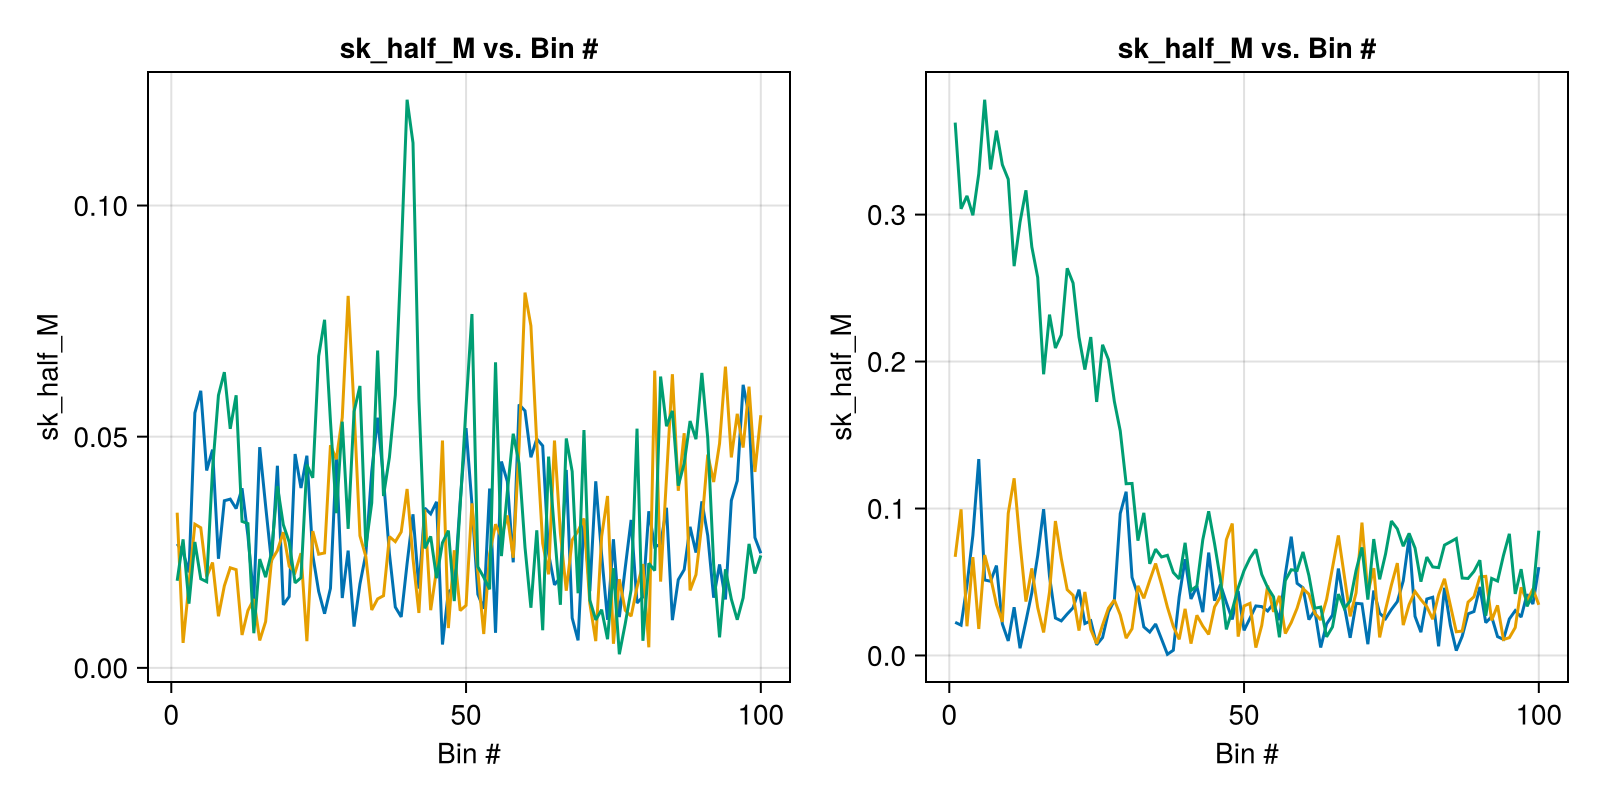

In [59]:
CairoMakie.activate!()
i = 12
var1 = :sk_half_M
var2 = :sk_half_M

fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
for j in 1:3
    label = getindex(['x', 'y', 'z'], j)
    lines!(ax1, abs.(getindex.(bias_mctimes[i][:, var1], j)); label)
    lines!(ax2, abs.(getindex.(bias_mctimes[i+1][:, var2], j)); label)
end
fig

In [54]:
CairoMakie.activate!()
is = [1, 6, 11]

spink_corrs = bias_results[:spink_corrs]
Bs = bias_results[:B]
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[i][I...] for I in path for i in is], :val))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.([spink_corrs[i][I...] for I in path for i in is], :val))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

ArgumentError: ArgumentError: column name :spink_corrs not found in the data frame

In [55]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Bs = bias_results[:B]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 6, 11] .+ 22
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = bias_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="B=$(Bs[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

ArgumentError: ArgumentError: column name "ηk_xx" not found in the data frame; existing most similar names are: "ηk_M" and "ηk_Γ"

## Eta-Only Runs

In [40]:
eta_results = JobResult("../jobs", "stripe-eta")
clean_corrs!(eta_results.data)

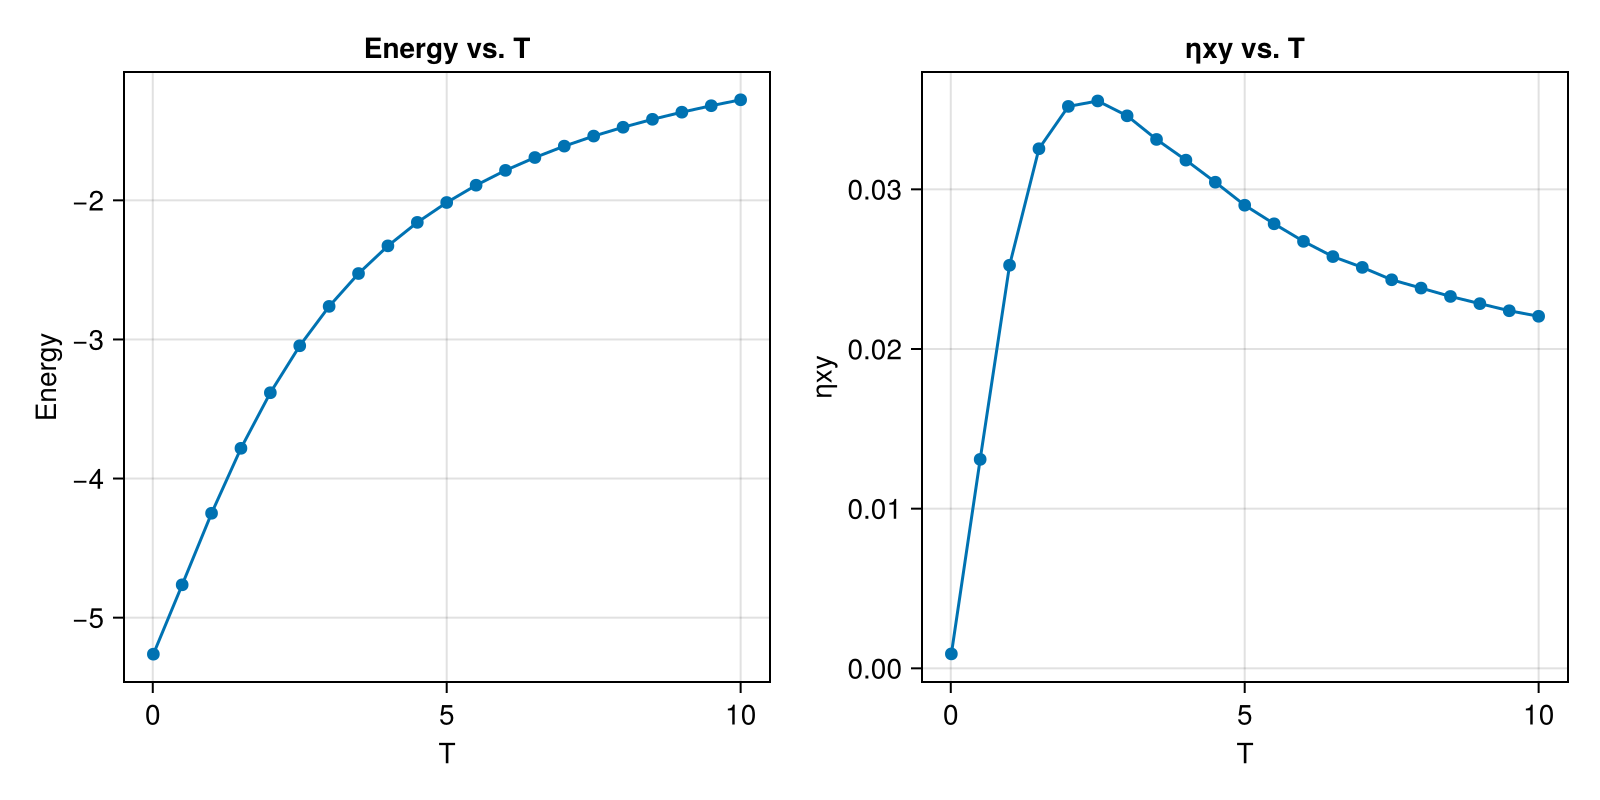

In [41]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Energy vs. T", xlabel="T", ylabel="Energy")
generate_plot!(ax_s, :T, :Energy, eta_results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, eta_results.data; line=true)
fig

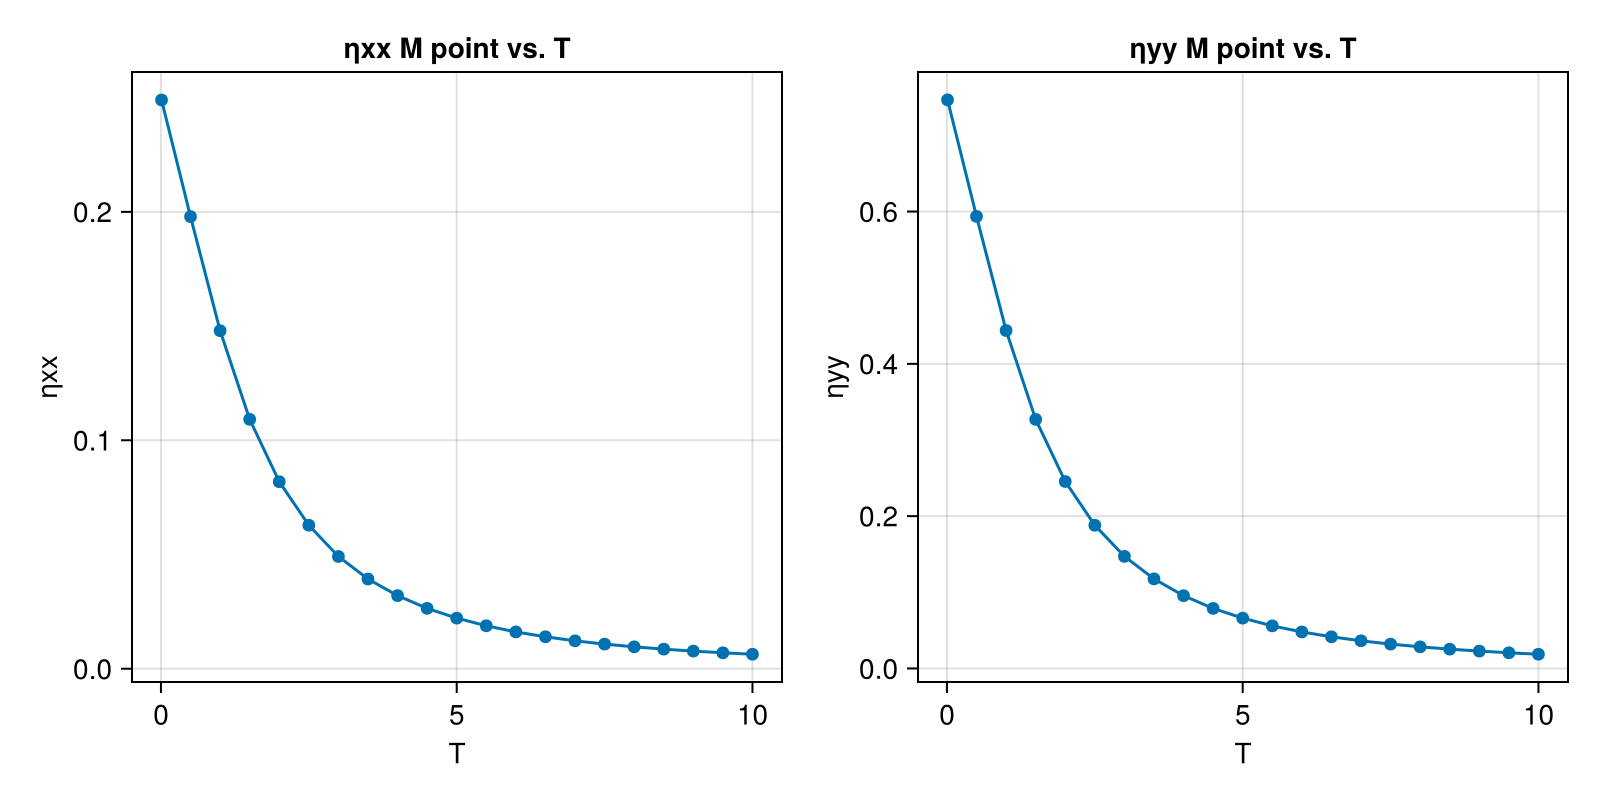

In [42]:
fig = Figure(size=(800, 400))

fig[1,1] = ax_ηx = Axis(fig, title="ηxx M point vs. T", xlabel="T", ylabel="ηxx")
generate_plot!(ax_ηx, :T, :ηk_xx_M, eta_results.data; line=true)
fig[1,2] = ax_ηy = Axis(fig, title="ηyy M point vs. T", xlabel="T", ylabel="ηyy")
generate_plot!(ax_ηy, :T, :ηk_yy_M, eta_results.data; line=true)

fig

In [15]:
eta_mctimes = get_mctime_data(eta_results, :etak_corrs)
separate_etaks!.(eta_mctimes)

21-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

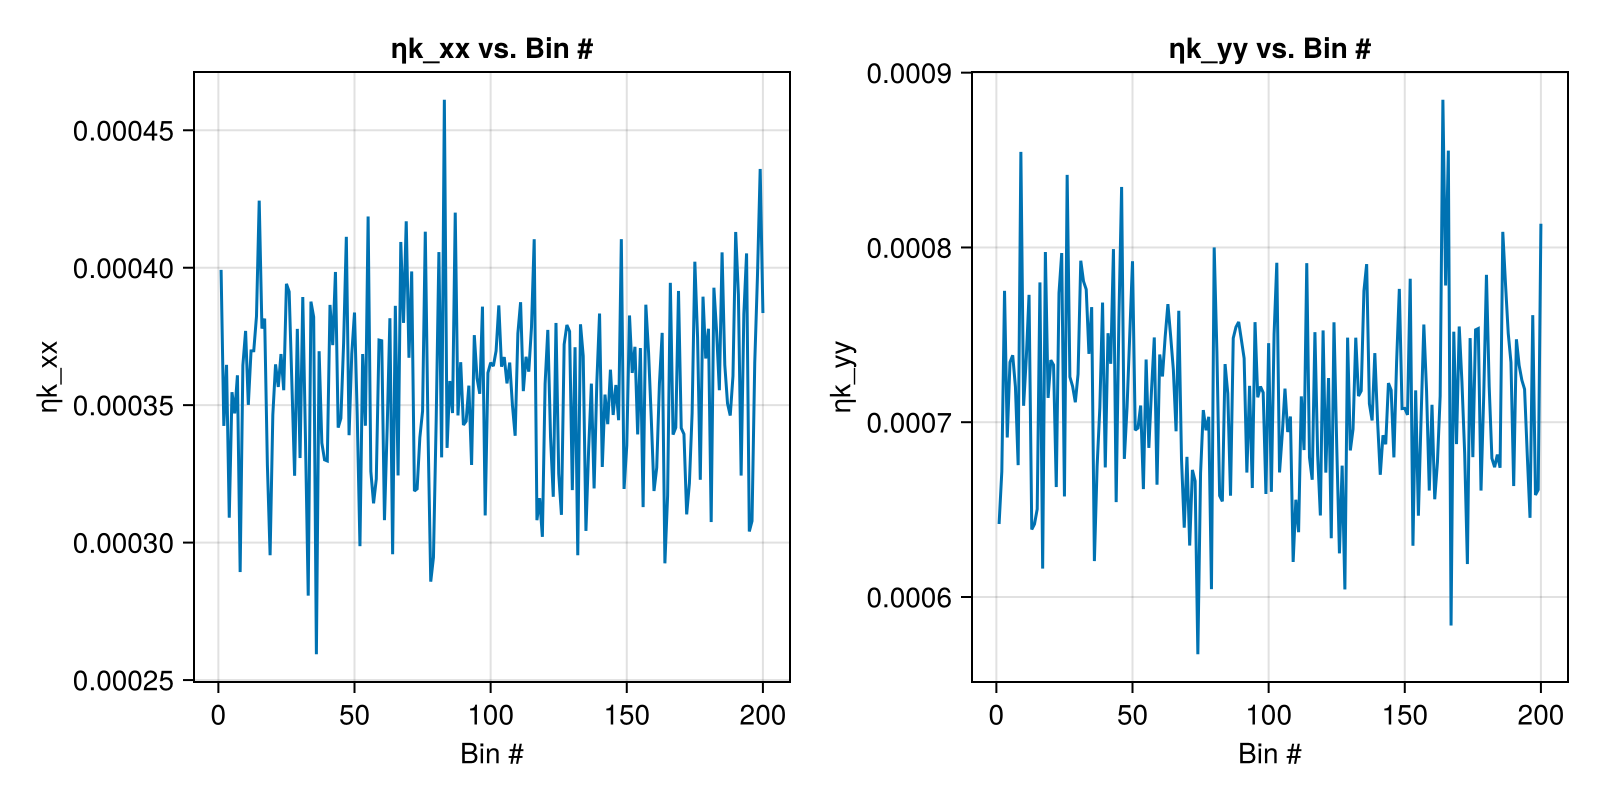

In [16]:
CairoMakie.activate!()
i = 10
k_pos = (1, 1)

var1 = :ηk_xx
var2 = :ηk_yy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(eta_mctimes[i][:, var1], k_pos...)))
lines!(ax2, abs.(getindex.(eta_mctimes[i][:, var2], k_pos...)))
fig

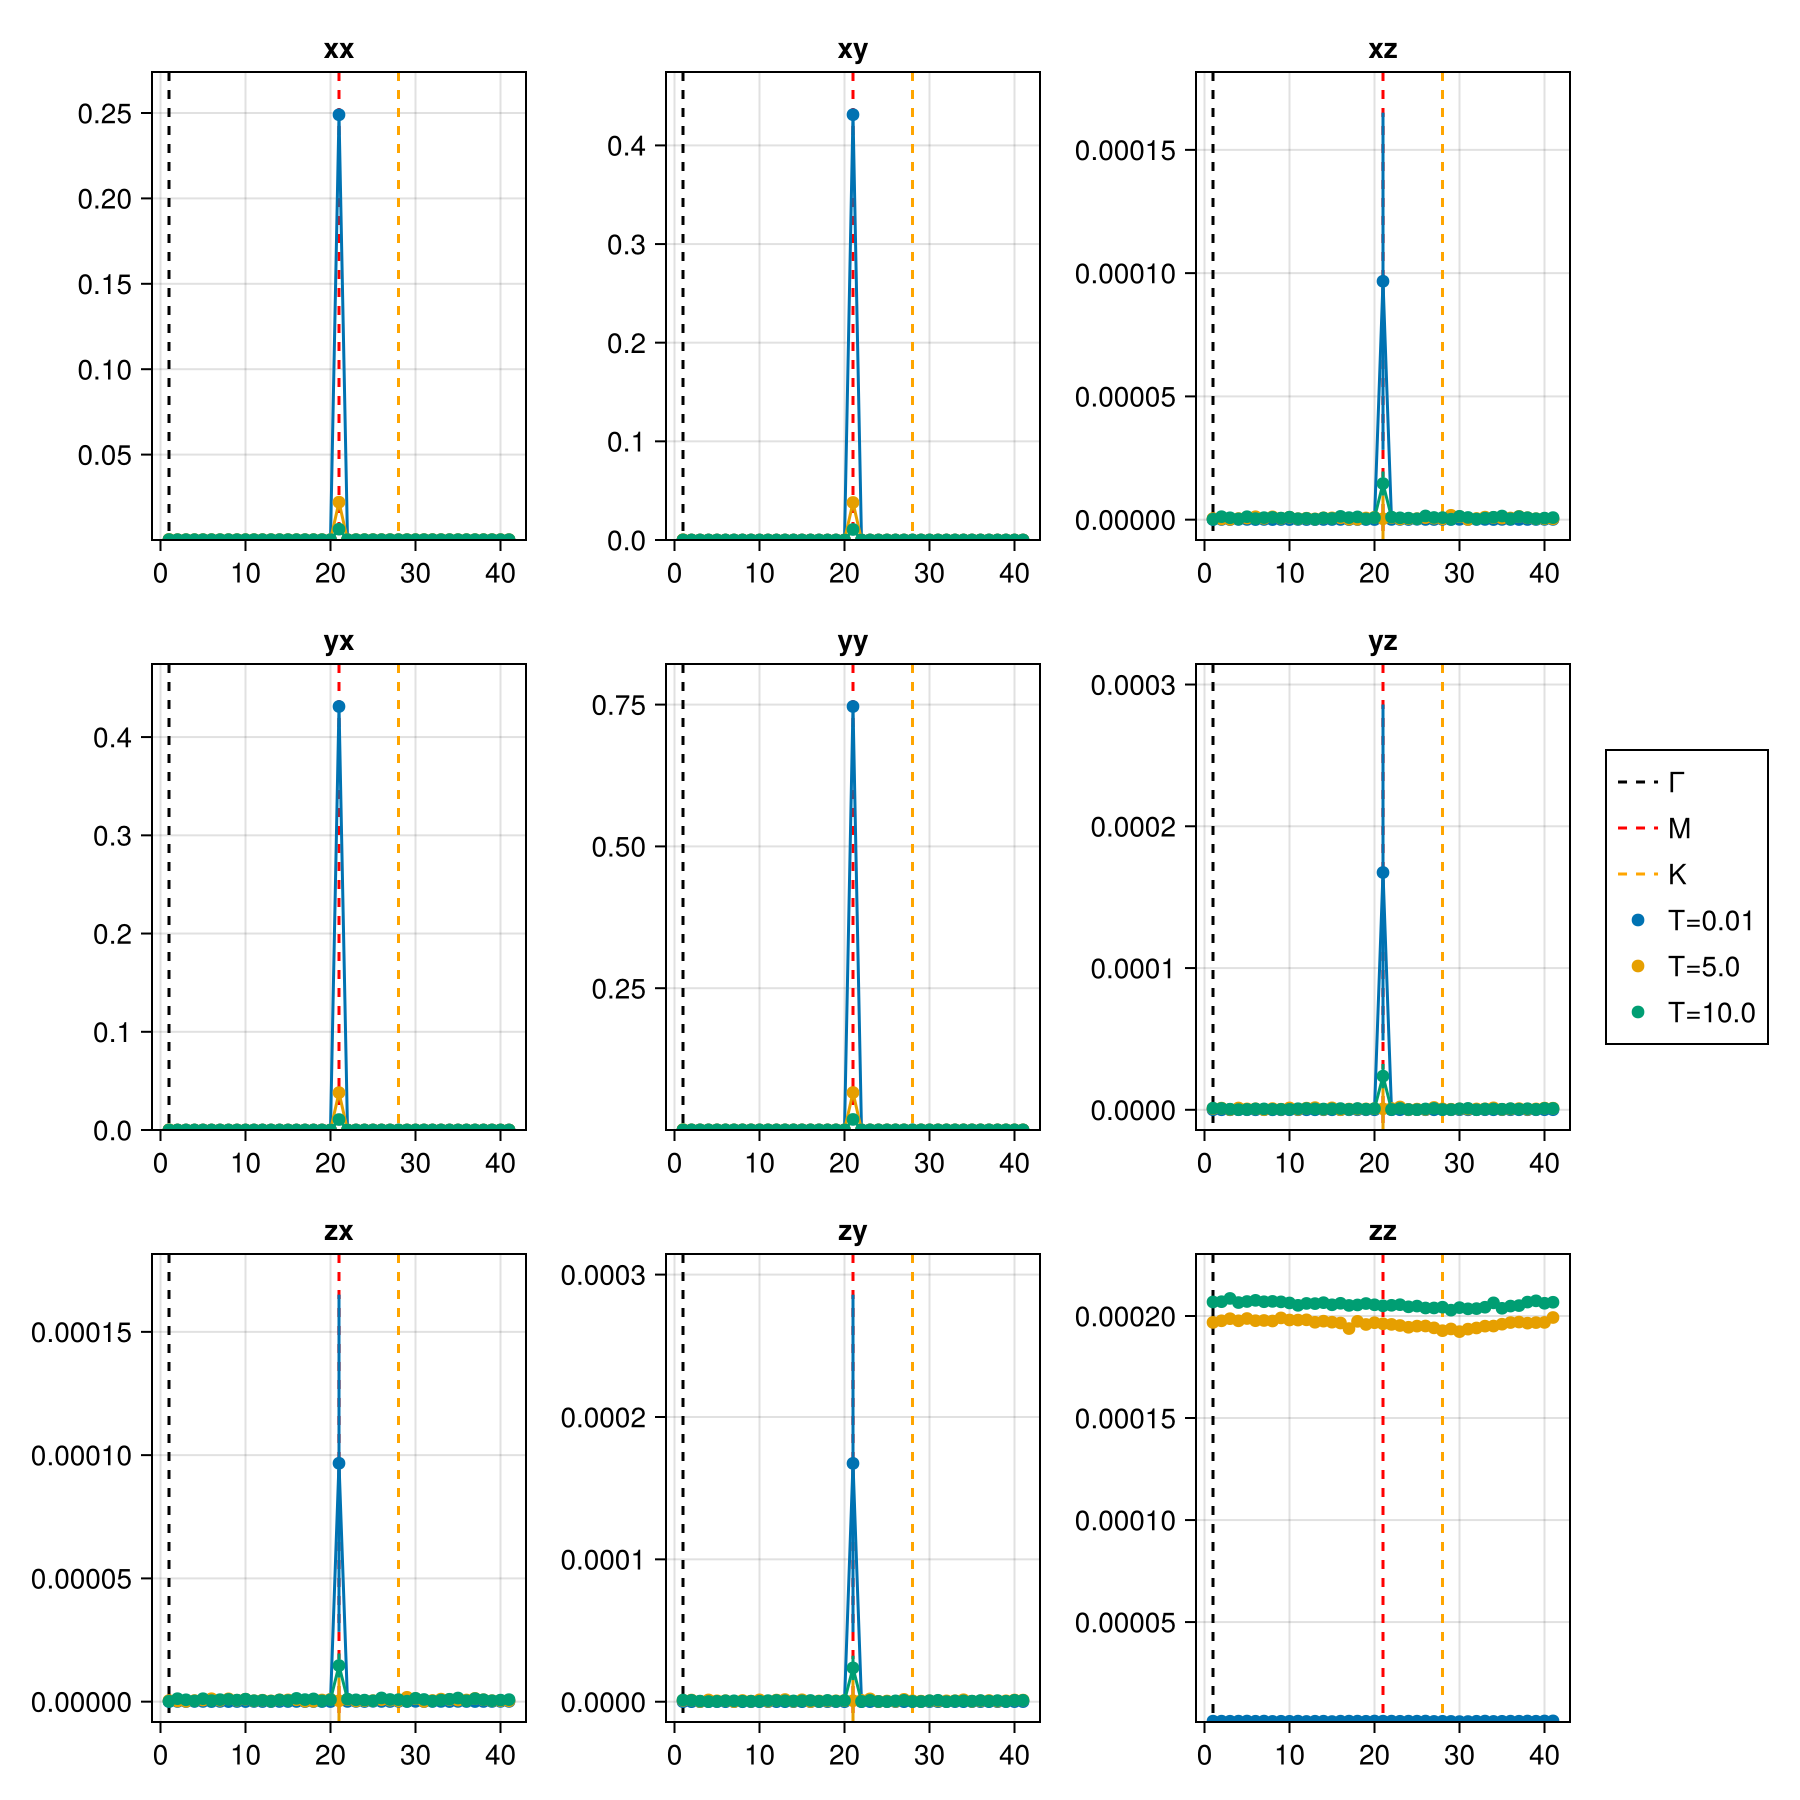

In [17]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Ts = eta_results[:T]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 11, 21]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = eta_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="T=$(Ts[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

## a_M Sweep

In [39]:
results = JobResult("../jobs", "stripe-param")
separate_etaks!(results.data)

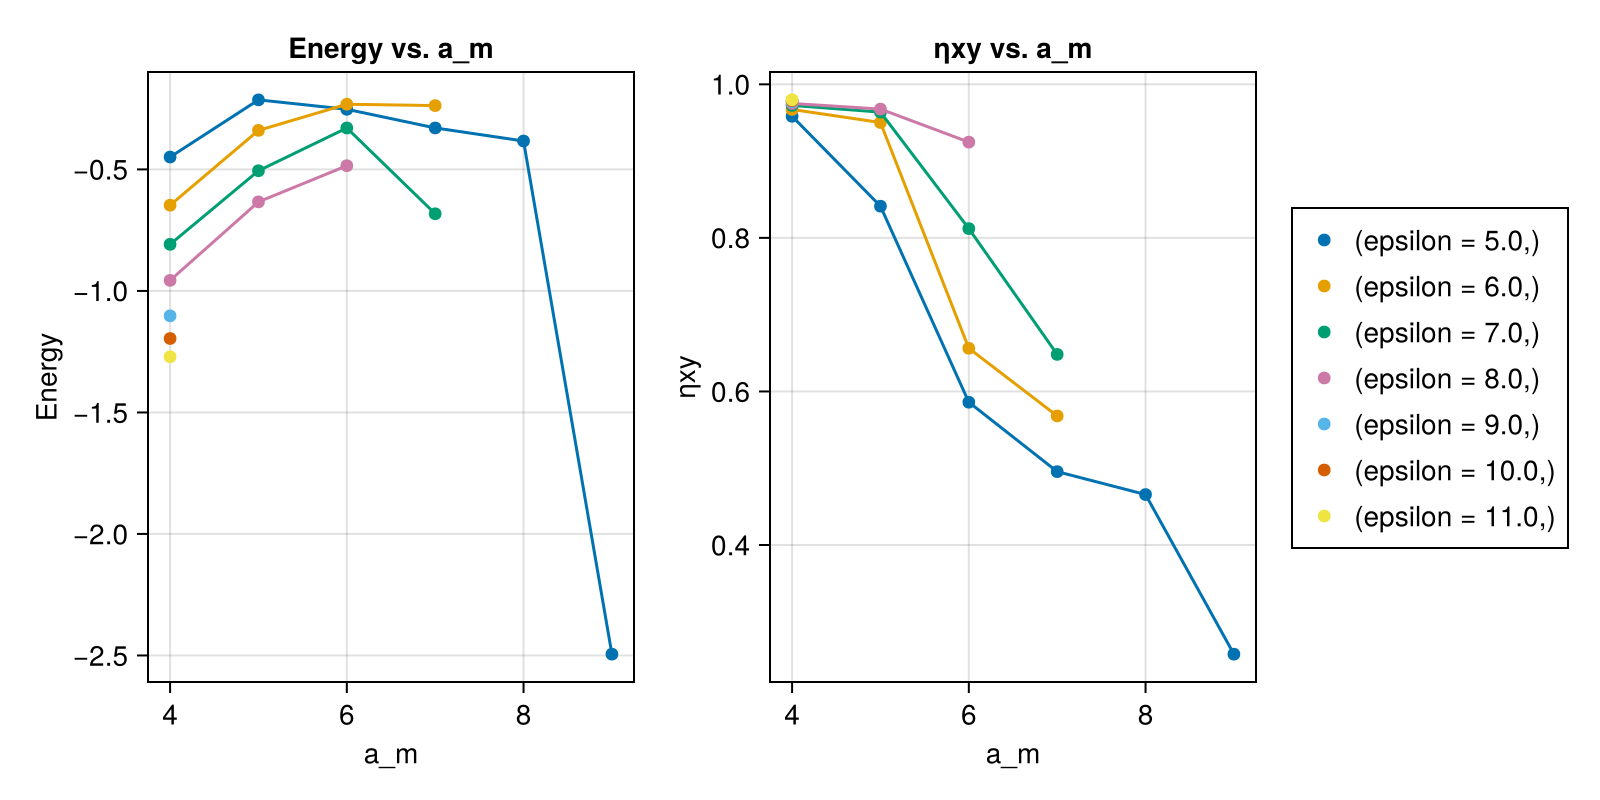

In [40]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Energy vs. a_m", xlabel="a_m", ylabel="Energy")
generate_plot!(ax_s, :a_m, :Energy, [:epsilon], results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. a_m", xlabel="a_m", ylabel="ηxy")
generate_plot!(ax_η, :a_m, :ηxy, [:epsilon], results.data; line=true)
Legend(fig[1,3], ax_η)
fig

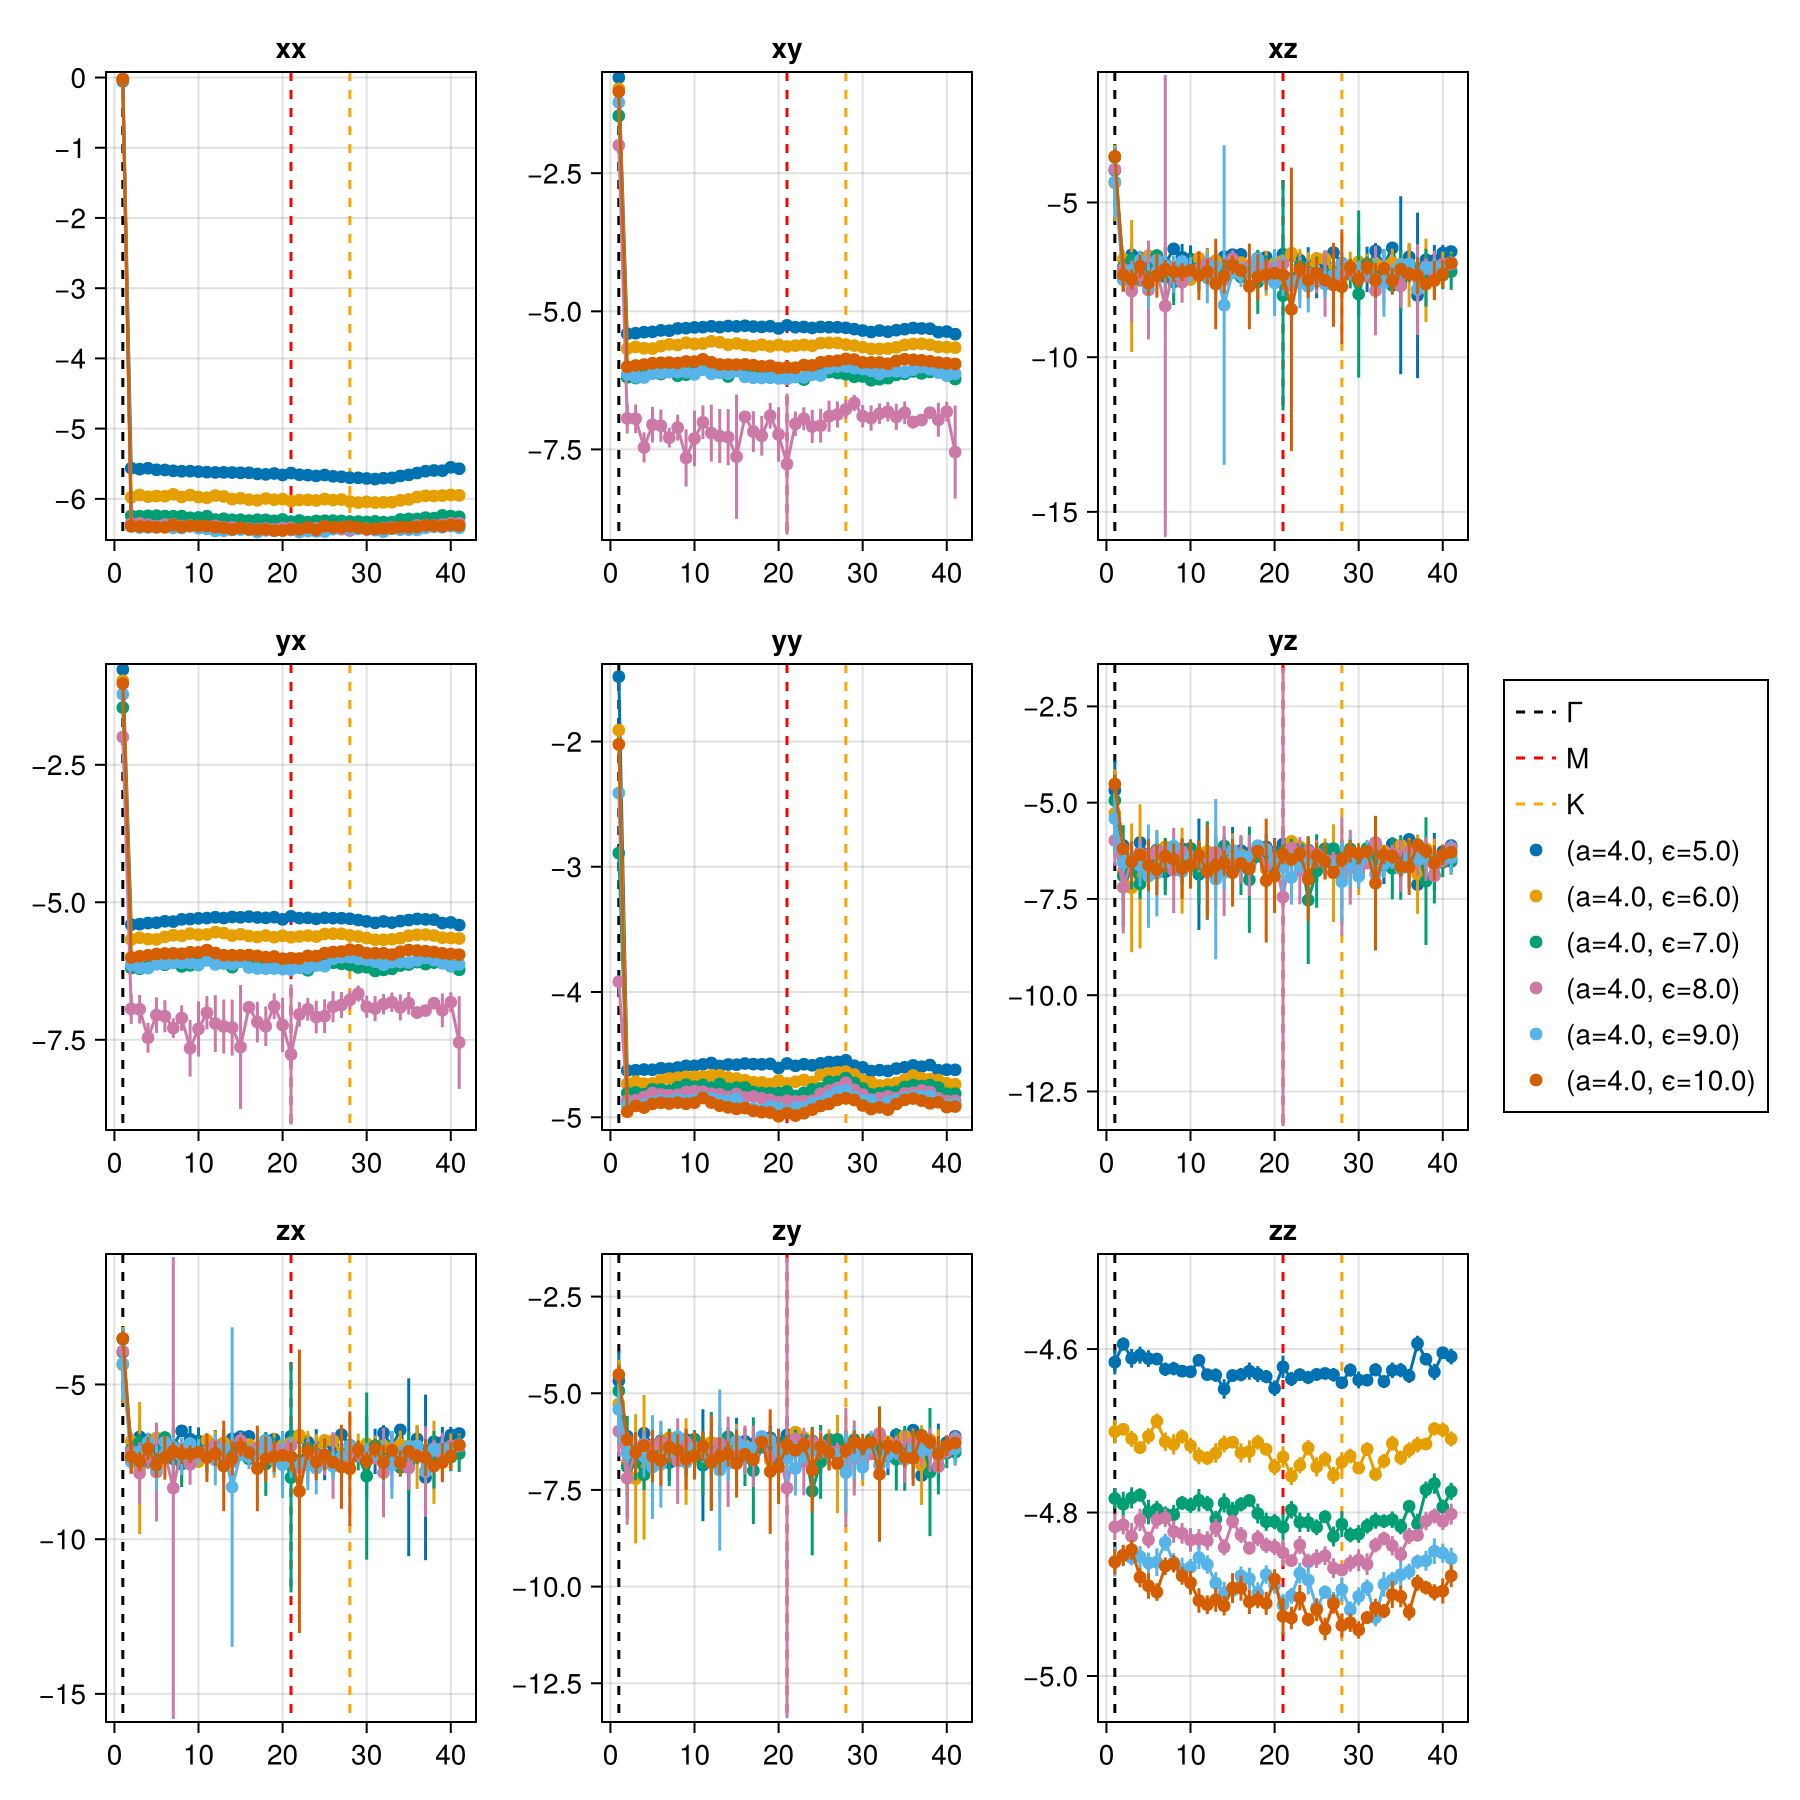

In [41]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
as = results[:a_m]
es = results[:epsilon]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 2, 3, 4, 5, 6]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]
    corr_matrices = results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)

    all_corrs = log10.([abs(corr_matrices[i][I...]) for I in path for i in is])
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = min_corr - 0.1
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = max_corr + 0.1
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = log10.(abs.(corr_matrices[i]))
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(corrs, :val)
        corr_errs = getfield.(corrs, :err)
        scatter!(ax, corr_vals, label="(a=$(as[i]), ϵ=$(es[i]))")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

In [42]:
mctimes = get_mctime_data(results, :etak_corrs)
separate_etaks!.(mctimes)

20-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

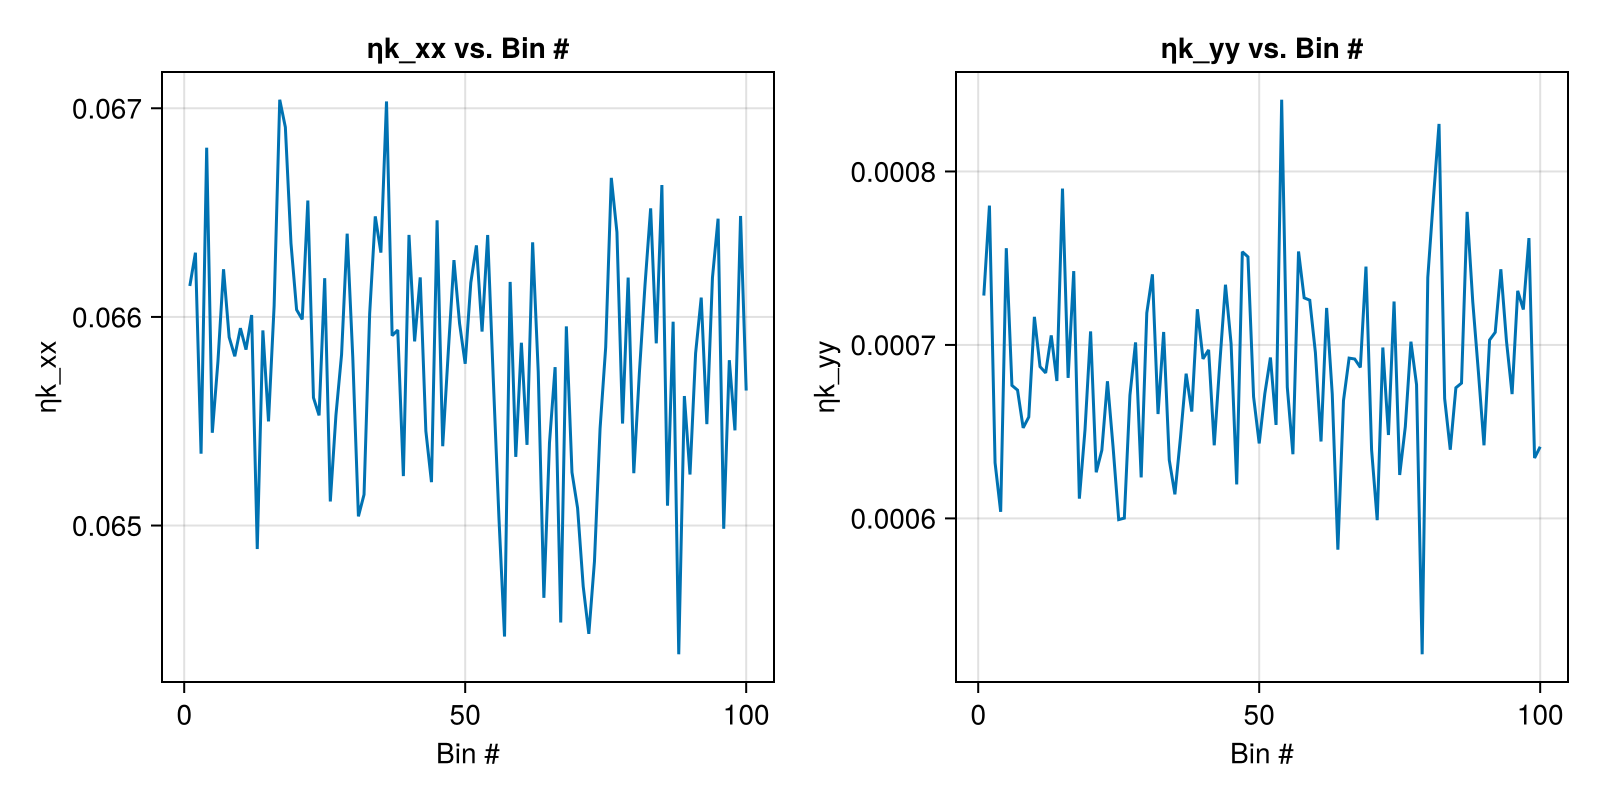

In [43]:
CairoMakie.activate!()
i = 20
k_pos = (1, 1)

var1 = :ηk_xx
var2 = :ηk_yy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(mctimes[i][:, var1], k_pos...)))
lines!(ax2, abs.(getindex.(mctimes[i][:, var2], k_pos...)))
fig

## Single Coupling Runs

In [13]:
results = JobResult("../jobs", "stripe-single-j")
separate_etaks!(results.data)

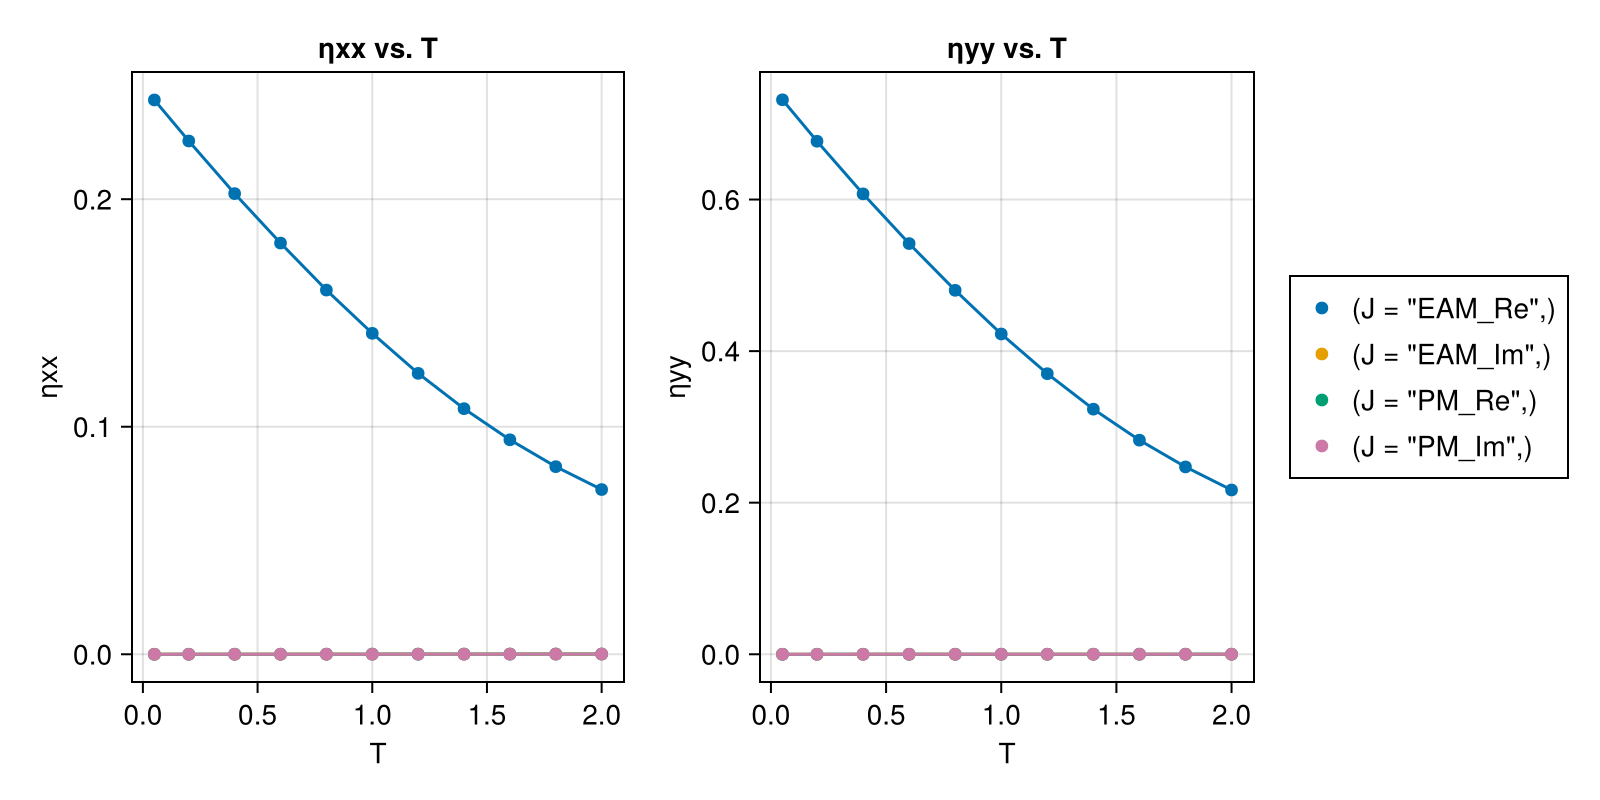

In [14]:
fig = Figure(size=(800, 400))

fig[1,1] = ax_ηx = Axis(fig, title="ηxx vs. T", xlabel="T", ylabel="ηxx")
generate_plot!(ax_ηx, :T, :ηk_xx_Γ, [:J], results.data; line=true)
fig[1,2] = ax_ηy = Axis(fig, title="ηyy vs. T", xlabel="T", ylabel="ηyy")
generate_plot!(ax_ηy, :T, :ηk_yy_Γ, [:J], results.data; line=true)

Legend(fig[1,3], ax_ηy)

fig

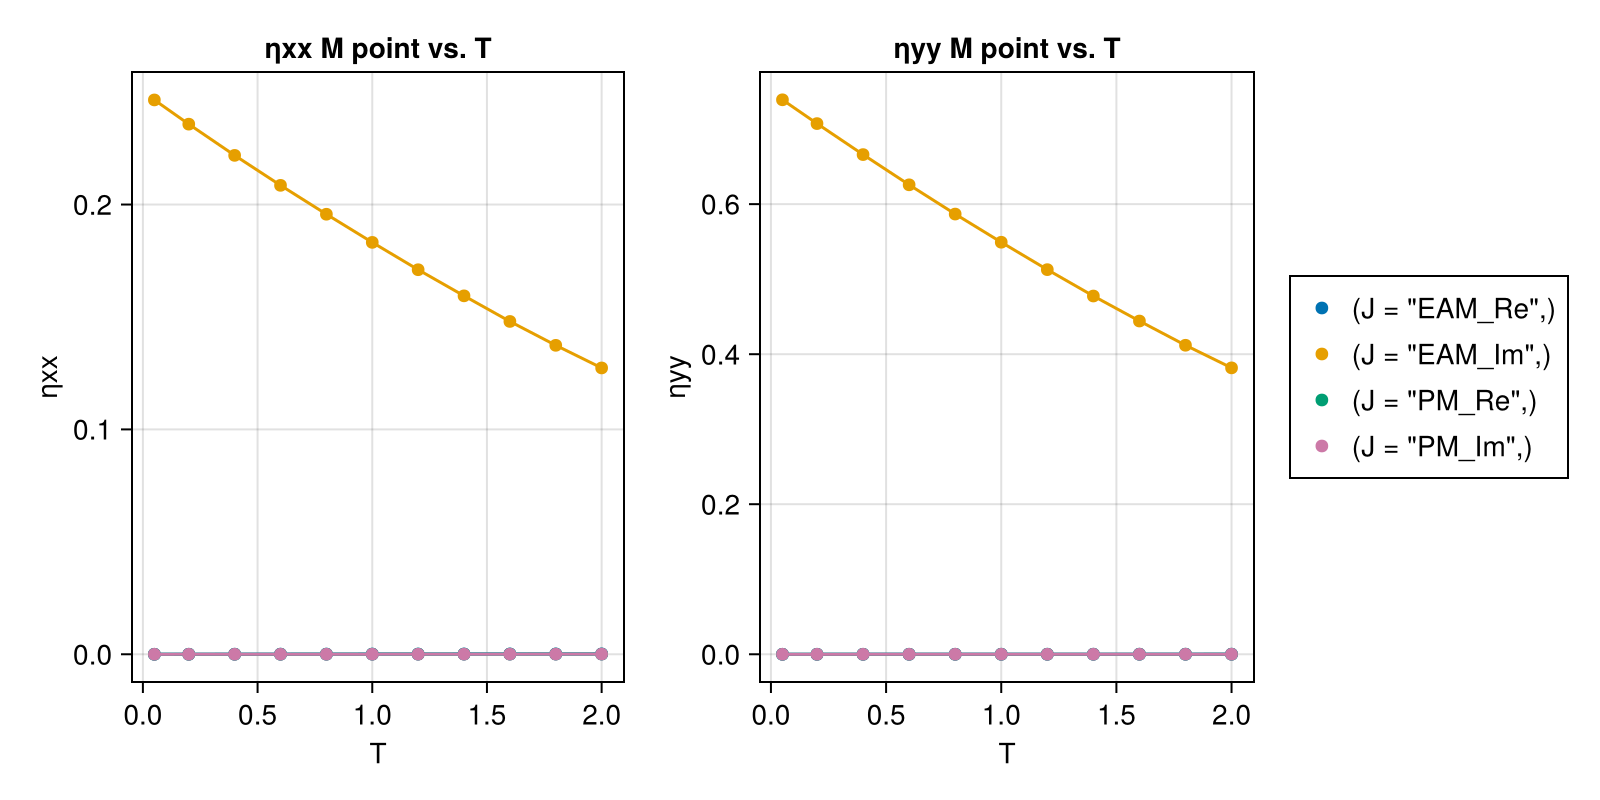

In [15]:
fig = Figure(size=(800, 400))

fig[1,1] = ax_ηx = Axis(fig, title="ηxx M point vs. T", xlabel="T", ylabel="ηxx")
generate_plot!(ax_ηx, :T, :ηk_xx_M, [:J], results.data; line=true)
fig[1,2] = ax_ηy = Axis(fig, title="ηyy M point vs. T", xlabel="T", ylabel="ηyy")
generate_plot!(ax_ηy, :T, :ηk_yy_M, [:J], results.data; line=true)

Legend(fig[1,3], ax_ηy)

fig

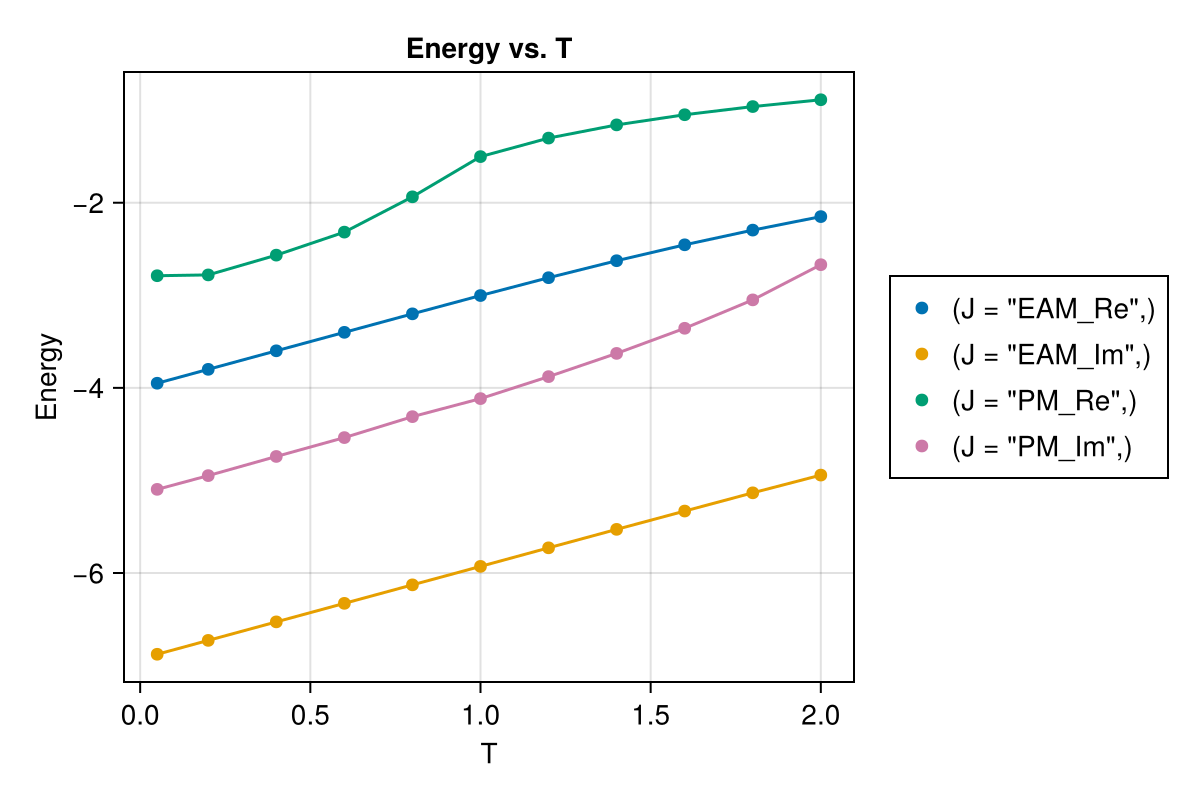

In [16]:
fig = Figure(size=(600, 400))
fig[1,1] = ax_e = Axis(fig, title="Energy vs. T", xlabel="T", ylabel="Energy")
generate_plot!(ax_e, :T, :Energy, [:J], results.data; line=true)
Legend(fig[1,2], ax_e)
fig

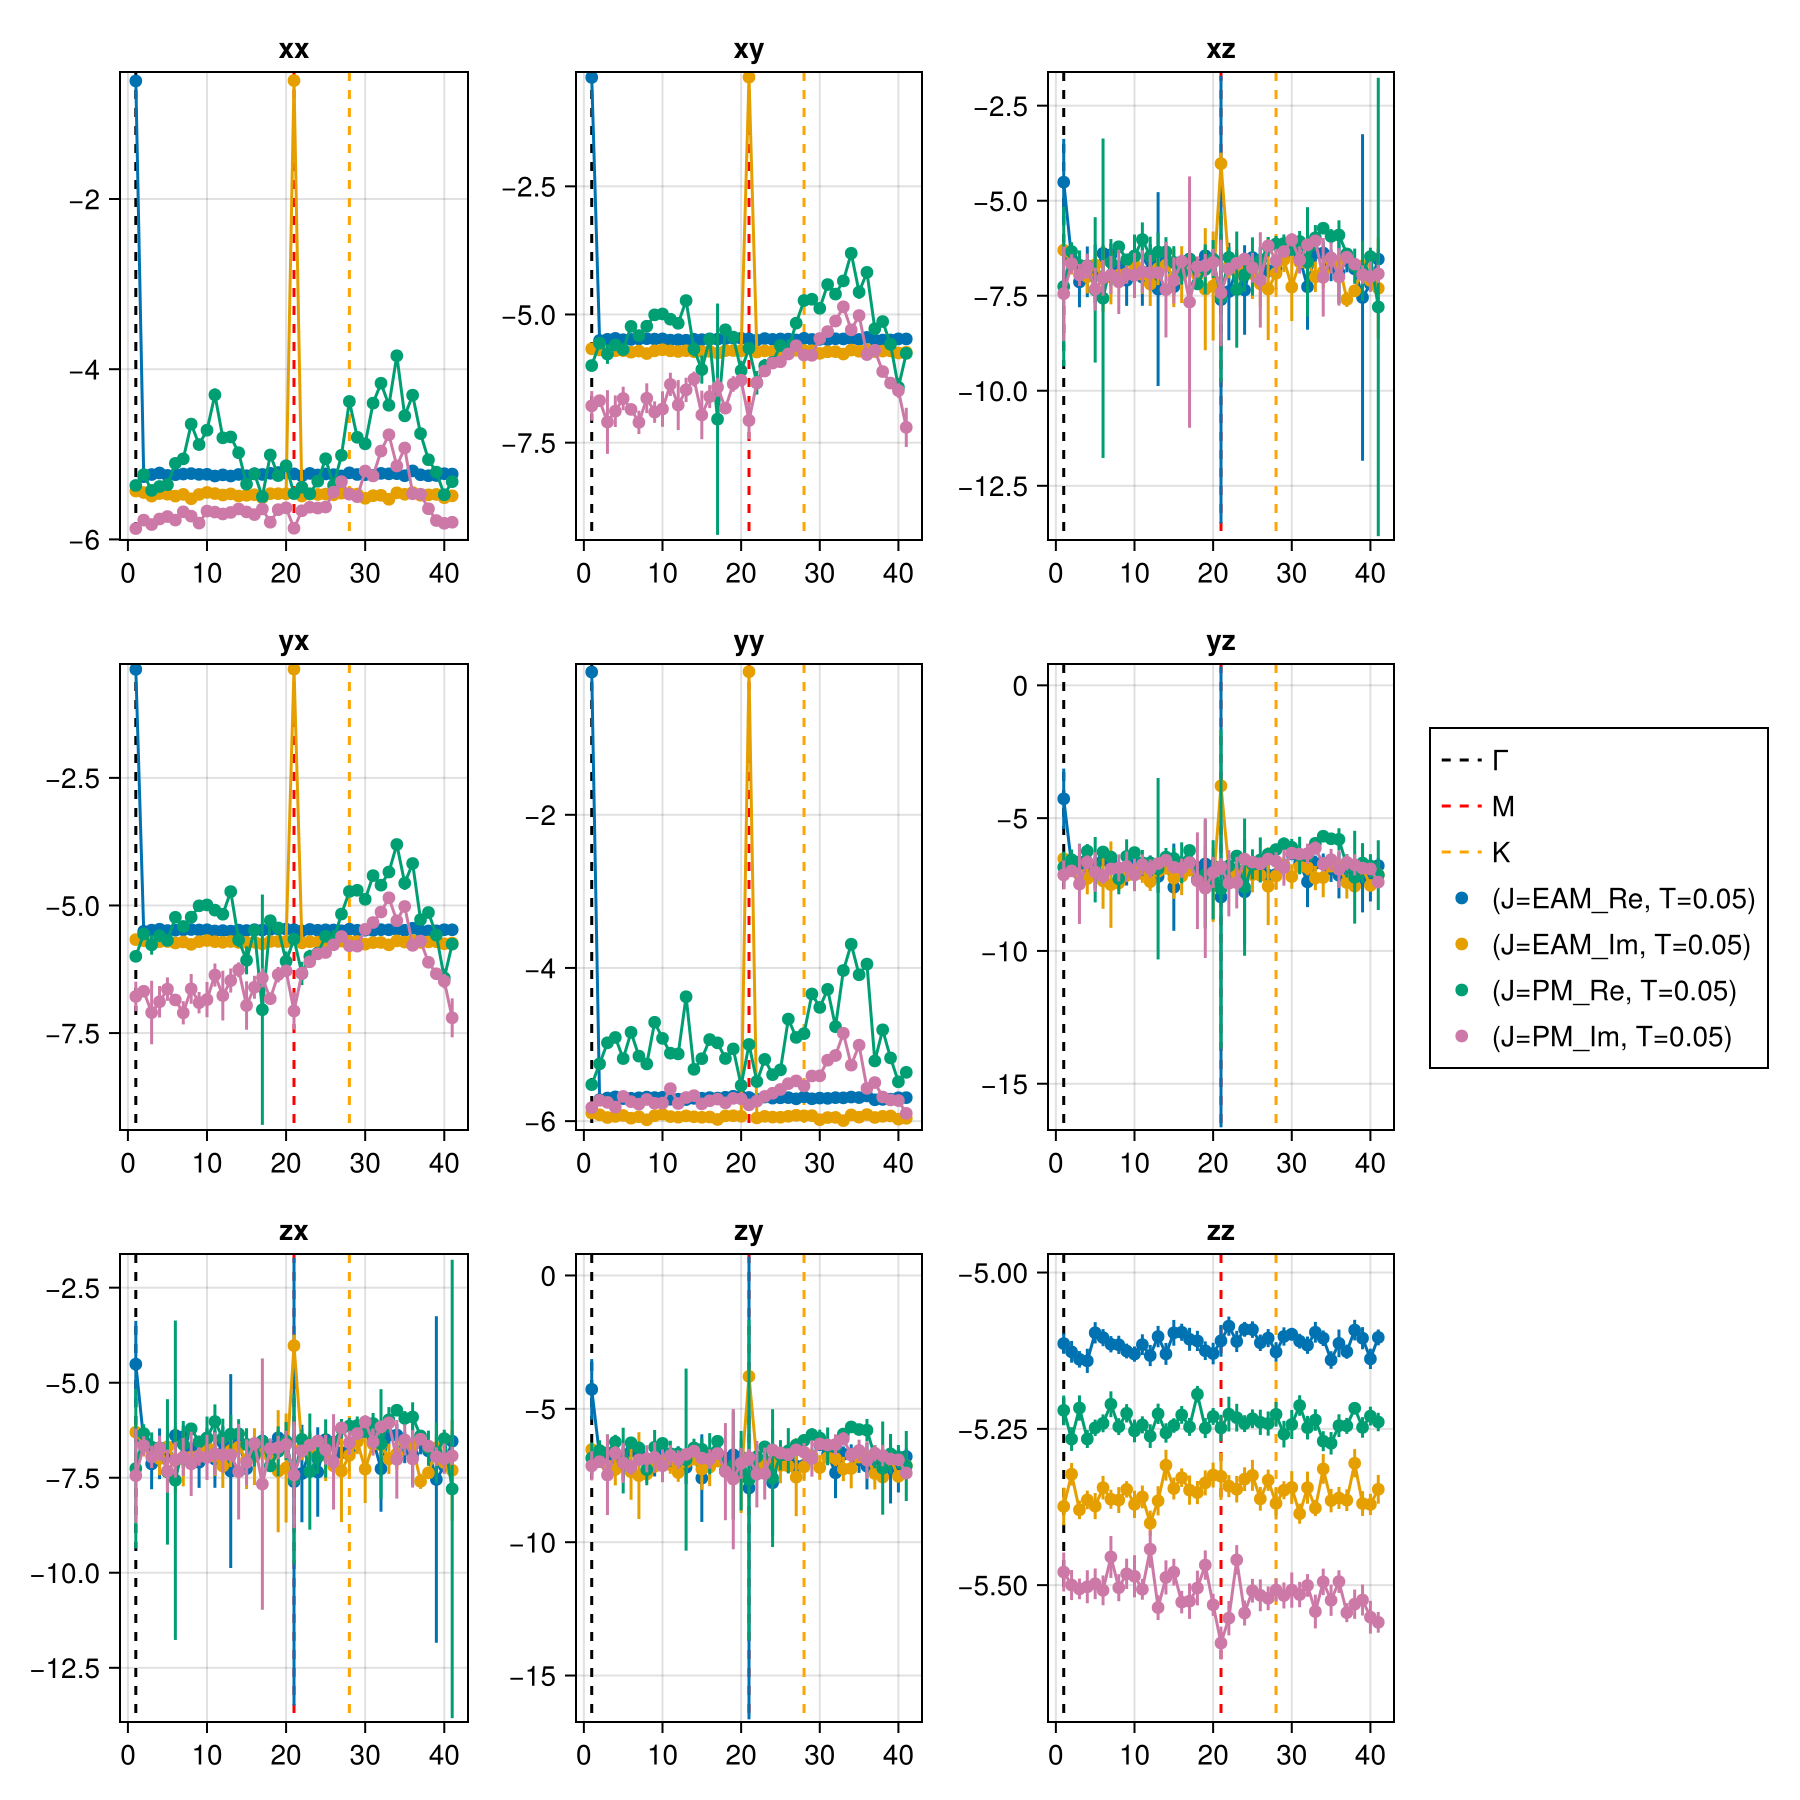

In [17]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Js = results[:J]
Ts = results[:T]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 12, 23, 34]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]
    corr_matrices = results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)

    all_corrs = log10.([abs(corr_matrices[i][I...]) for I in path for i in is])
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = min_corr - 0.1
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = max_corr + 0.1
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = log10.(abs.(corr_matrices[i]))
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(corrs, :val)
        corr_errs = getfield.(corrs, :err)
        scatter!(ax, corr_vals, label="(J=$(Js[i]), T=$(Ts[i]))")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

In [18]:
mctimes = get_mctime_data(results, :etak_corrs)
separate_etaks!.(mctimes)

44-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

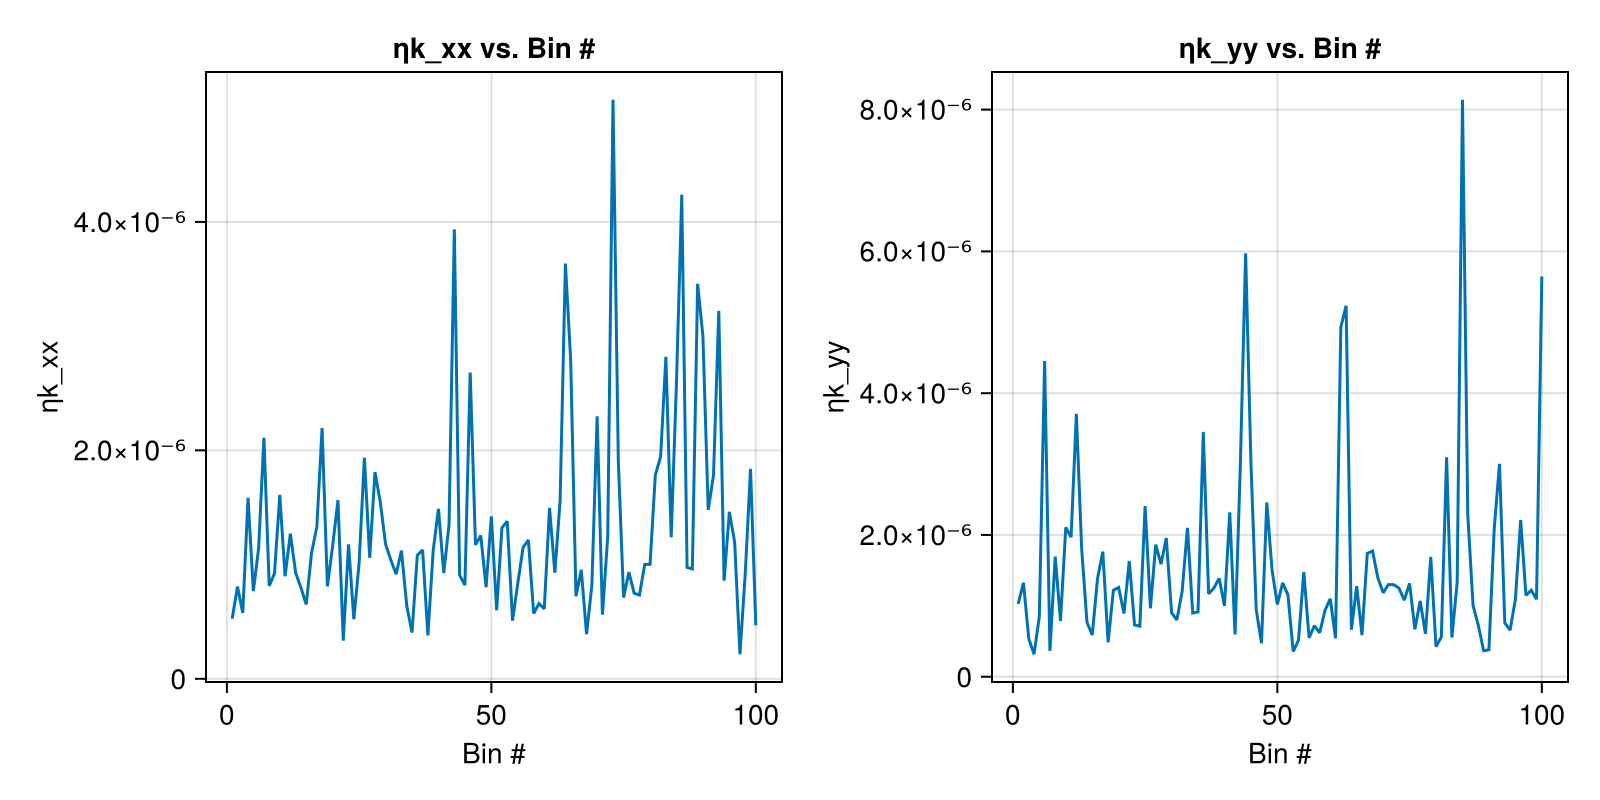

In [19]:
CairoMakie.activate!()
i = 34
k_pos = (1, 1)

var1 = :ηk_xx
var2 = :ηk_yy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(mctimes[i][:, var1], k_pos...)))
lines!(ax2, abs.(getindex.(mctimes[i][:, var2], k_pos...)))
fig